In [15]:
# Goal of the project is to apply ML to real data

# Step 1: just plot the data
# Step 2: which task? Supervised Learning!
# Step 3: train and test a few methods

# Comments on different algorithms, expenses, difficulties, findings?

In [19]:
# Here I want to use a CNN for reproducing the 'probability' distribution of all classes and sub-classes

In [1]:
# Loading the data

# What are the GalaxyIDs? I can read them from the first column of the training_solutions file

import skimage
from skimage import data
from skimage import io

import numpy as np
import os
import csv

# I read the file and create the list of IDs as well as the list of labels
with open("training_solutions_rev1.csv", 'r') as f: 
    reader = csv.reader(f, delimiter=",")
    train_ids = []
    y = []
    for k, line in enumerate(reader):
        if k == 0: continue # skip header
        train_ids.append(int(line[0]))
        y.append(line[1:])
        
train_ids = np.array(train_ids) # I save the IDs in this numpy array
my_train_ids = train_ids[0:800] # I want to work with less training data for computational cost reasons
my_valid_ids = train_ids[800:900] # galaxies IDs for my validation test (to chooose between my models)
my_test_ids = train_ids[900:1000] # These I choose to be the galaxies IDs for my final-test

# same split for the labels
y = np.asarray(y, dtype=float)  #change type of elements from string to float!
y_train = y[0:800]
y_valid = y[800:900]
y_test = y[900:1000]

# same split for the data points
x_train = []
x_valid = []
x_test = []
for ID in my_train_ids:
    filename = 'images_training_rev1/' + str(ID) + '.jpg'
    x_train.append(io.imread(filename))
for ID in my_valid_ids:
    filename = 'images_training_rev1/' + str(ID) + '.jpg'
    x_valid.append(io.imread(filename))
for ID in my_test_ids:
    filename = 'images_training_rev1/' + str(ID) + '.jpg'
    x_test.append(io.imread(filename))
x_train = np.array(x_train)
x_valid = np.array(x_valid)
x_test = np.array(x_test)

In [2]:
# Each data point is an image of 424x424 pixels, 
# where each pixel is a set of 3 numbers giving the RGB intensities

x_train = np.asarray(x_train, dtype=float)
x_valid = np.asarray(x_valid, dtype=float)
x_test = np.asarray(x_test, dtype=float)

print('The number of values characterizing each image is:')
print(424*424*3)
print('The shape of each data point is:')
print(x_train[0].shape)

print('The shapes of the training points and of the labels are:')
print(x_train.shape, y_train.shape)

The number of values characterizing each image is:
539328
The shape of each data point is:
(424, 424, 3)
The shapes of the training points and of the labels are:
(800, 424, 424, 3) (800, 37)


In [4]:
# Comments:
# 1. I can use COLAB, a google notebook that connects to a GPU in the worlds...

In [3]:
import tensorflow as tf
print(tf.__version__) 

2.0.0


In [4]:
# I want to construct a CNN because the images have a lot of pixels
# implying a lot of weigths to learn...
# It is smart to use filters (convolutional layers) to detect patterns
# e.g. spiral arms, bars, round shapes, edge-on disks, bulges, rings, exc...

In [25]:
#Normalization generally leads to faster learning/convergence - a good practice!
x_train = tf.keras.utils.normalize(x_train, axis=1)
x_valid = tf.keras.utils.normalize(x_valid, axis=1)

#We define a linear-style neural network, one of the simplest models
model = tf.keras.models.Sequential()

In [26]:
# 1st convolution layer with 10 large filters 
model.add(tf.keras.layers.Conv2D(10,(7,7),input_shape=(424, 424, 3)))

# 1st pooling layer to coarse-grain by a factor of 4 (get the size of a galaxy)
model.add(tf.keras.layers.MaxPooling2D(pool_size=(4,4)))

# 2nd convolution layer with 10 smaller filters
model.add(tf.keras.layers.Conv2D(10,(5,5),input_shape=(106, 106, 3)))

# 2nd pooling layer to coarse-grain by a factor of 2
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

In [27]:
# Flatten the input in 1D array 
model.add(tf.keras.layers.Flatten())

# Dense layer with 128 neurons
model.add(tf.keras.layers.Dense(128,activation = tf.nn.relu))

# For the final layer, the output layer, we transform the output from the previous layer
# to a probability distribution across 37 classes
last_layer = 37
model.add(tf.keras.layers.Dense(last_layer,activation = tf.nn.softmax))

# I choose the loss function and the optimizer ('adam' is a variant of SGD)
model.compile(optimizer="adam",loss=tf.keras.losses.Huber(),metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])

In [28]:
model.fit(x_train, y_train,epochs = 4)

Train on 800 samples
Epoch 1/4
800/800 [==============================] - 19s 24ms/sample - loss: 0.0265 - rmse: 0.2302
Epoch 2/4
800/800 [==============================] - 21s 27ms/sample - loss: 0.0247 - rmse: 0.2221
Epoch 3/4
800/800 [==============================] - 22s 27ms/sample - loss: 0.0242 - rmse: 0.2202
Epoch 4/4
800/800 [==============================] - 21s 27ms/sample - loss: 0.0240 - rmse: 0.2190


In [9]:
# CNN took 30s per epoch with 800 training points 

# rmse = 0.22 with Huber loss (a good value of rmse is 0.1)
# rmse = 0.23 with Binary-Crossentropy loss (a good value of rmse is 0.1)

# Improvable with modifications below and more epochs and training points

# Improvements that I could do:
# 1) crop the images with pytorch 
        # funzione gia' fatta in transforms center_crop
# 2) add more layers, windows max 7x7

In [29]:
#Let's evaluate the model
#.evaluate() returns the loss and metrics (accuracy for us) for the test sample
val_loss, val_rmse = model.evaluate(x_valid, y_valid)
print(val_loss, val_rmse)

100/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [23]:
# rmse = 0.21 ...large margin of improvement
# the first 50 scores in the ranking are 0.07-0.1

In [30]:
#Saves the model in a folder in the working directory
model.save("CNN_Galaxies_regression")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: CNN_Galaxies_regression/assets


Predicted labels
[9.18099582e-02 1.46412507e-01 4.49519000e-08 5.44670456e-07
 1.92524984e-01 7.10304491e-08 3.02002262e-02 5.11571045e-07
 3.80428077e-07 5.50719687e-06 3.37866872e-08 5.54081510e-07
 6.31510659e-07 1.85004274e-06 5.39012313e-01 1.21218272e-05
 4.71031456e-07 4.01077045e-07 6.62159616e-09 4.80265135e-06
 1.00242396e-07 2.88161289e-07 2.42354645e-06 1.15826992e-07
 4.62819791e-08 3.79312667e-07 6.97294865e-07 2.43504132e-07
 4.38709549e-06 2.43409630e-07 4.33074973e-07 4.44258248e-08
 4.91972116e-07 4.86171814e-07 1.38697453e-06 9.35263600e-09
 2.34245107e-07]
Human labels
[0.452045   0.522394   0.025561   0.07774947 0.44464453 0.20808164
 0.2365629  0.         0.44464453 0.         0.27770852 0.16693601
 0.         0.069786   0.930214   0.06767566 0.38436934 0.
 0.         0.         0.034893   0.034893   0.         0.
 0.         0.07774947 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]


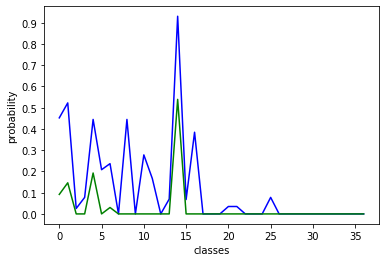

In [36]:
#Load the model
my_model = tf.keras.models.load_model("CNN_Galaxies_regression")

#Test the model
predictions = my_model.predict(x_valid)

#For a given index...
index = 3

#What do we predict?
print('Predicted labels')
print(predictions[index])

#What is the true value?
print('Human labels')
print(y_valid[index])

# I need to plot for a visual feeling
import matplotlib.pyplot as plt

plt.plot(np.arange(37), y_valid[index], c='b')
plt.plot(np.arange(37), predictions[index], c='g')
plt.yticks(np.arange(0,1,0.1))
plt.ylabel('probability')
plt.xlabel('classes')
plt.show()